## Imports

In [1]:
import os
import math
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from read_data import *

## Set Styles for transfer

In [2]:
styles = {
    0 : 'Gorodets',
    1 : 'Gzhel',
    2 : 'Iznik',
    3 : 'Khokhloma',
    4 : 'Neglyubka',
    5 : 'Wycinanki_Å‚owickie',
    6 : 'Wzory_kaszubskie'
}

style_X = styles[1]
style_Y = styles[4]

## Set saving / restoring

In [3]:
restoring_mode = False
saving_mode = False

restoring_name = 'first_model.ckpt'
saving_name = 'first_model.ckpt'

restoring_path = os.path.join('models', style_X + ' =|= ' + style_Y, restoring_name)
saving_path = os.path.join('models', style_X + ' =|= ' + style_Y, saving_name)

## Adjust Hyperparameters

In [4]:
EPOCHS = 1
BATCH_SIZE = 4
IMG_SIZE = 150

## Neural Network functions

### Convolution Layers

In [5]:
def conv_layer(X, filters, filter_size, stride, name, activation=None):
    """Create a new convolution layer with Xavier initializer"""
    
    with tf.variable_scope(name):
        
        # create Xavier initializer node 
        in_channels = int(X.get_shape()[3])
        init = tf.contrib.layers.xavier_initializer_conv2d()
    
        # create the parameter structures         
        W = tf.get_variable(initializer=init, 
                            shape=(filter_size[0], filter_size[1],
                                   in_channels, filters),
                            name="weights")
        b = tf.get_variable(initializer=tf.zeros(filters),
                            name="biases")
        
        # perform convolution and add bias
        conv = tf.nn.conv2d(X, W, strides=(1, stride, stride, 1), padding="SAME")
        z = tf.nn.bias_add(conv, b)
        
        # activation function
        if activation == "relu":
            return tf.nn.relu(z)
        elif activation == "sigmoid":
            return tf.nn.sigmoid(z)
        else:
            return z
     

def deconv_layer(X, filters, filter_size, stride, output_shape, name, activation=None):
    """Create a new deconvolution layer with Xavier initializer"""

    with tf.variable_scope(name):

        # create Xavier initializer node 
        in_channels = int(X.get_shape()[3])
        init = tf.contrib.layers.xavier_initializer_conv2d()

        # create the parameter structures         
        W = tf.get_variable(initializer=init,
                            shape=(filter_size[0], filter_size[1],
                                   filters, in_channels),
                            name="weights")
        b = tf.get_variable(initializer=tf.zeros(filters),
                            name="biases")

        # perform convolution and add bias
        conv = tf.nn.conv2d_transpose(X, W, output_shape=output_shape,
                                      strides=(1, stride, stride, 1), padding="SAME")
        z = tf.nn.bias_add(conv, b)

        # activation function
        if activation == "relu":
            return tf.nn.relu(z)
        else:
            return z
        
        
def residual_layer(X, filter_size, stride, name, activation=None):
    """Create a new residual convolution layer with Xavier initializer"""
    
    # get number of input filters     
    filters = in_channels = int(X.get_shape()[3])
    
    # add residuals to convolution     
    z = X + conv_layer(X, filters, filter_size, stride, name)

    # activation function
    if activation == "relu":
        return tf.nn.relu(z)
    else:
        return z

## Build the model and deploy it on a device

In [6]:
with tf.device('/cpu:0'):
    
    #==================[ READ AND PROCESS THE INPUT ]==================#
            
    # load training data from input queues     
    X = inputs(style_X, BATCH_SIZE, EPOCHS)
    Y = inputs(style_Y, BATCH_SIZE, EPOCHS)
    
    # normalize the images     
    X = (tf.cast(X, tf.float32) / 255.0)
    Y = (tf.cast(Y, tf.float32) / 255.0)

### Generators

In [7]:
with tf.device('/gpu:0'):
    
    #==================[ G(X) -> Y ]==================#
    
    X_conv_1 = conv_layer(X, 32, (9, 9), 1, "X_conv_1", "relu")
    X_conv_2 = conv_layer(X_conv_1, 64, (3, 3), 2, "X_conv_2", "relu")
    X_conv_3 = conv_layer(X_conv_2, 128, (3, 3), 2, "X_conv_3", "relu")
    
    X_res_1 = residual_layer(X_conv_3, (1, 1), 1, "X_res_1", "relu")
    X_res_2 = residual_layer(X_res_1, (1, 1), 1, "X_res_2", "relu")
    X_res_3 = residual_layer(X_res_2, (1, 1), 1, "X_res_3", "relu")
    
    X_deconv_2 = deconv_layer(X_res_3, 64, (3, 3), 2, [BATCH_SIZE, 75, 75, 64], "X_deconv_2", "relu")
    X_deconv_1 = deconv_layer(X_deconv_2, 32, (3, 3), 2, [BATCH_SIZE, 150, 150, 32], "X_deconv_1", "relu")
    G_x = deconv_layer(X_deconv_1, 3, (9, 9), 1, [BATCH_SIZE, 150, 150, 3], "G_x", "relu")
    
    #==================[ F(Y) -> X ]==================#
    
    Y_conv_1 = conv_layer(Y, 32, (9, 9), 1, "Y_conv_1", "relu")
    Y_conv_2 = conv_layer(Y_conv_1, 64, (3, 3), 2, "Y_conv_2", "relu")
    Y_conv_3 = conv_layer(Y_conv_2, 128, (3, 3), 2, "Y_conv_3", "relu")
    
    Y_res_1 = residual_layer(Y_conv_3, (1, 1), 1, "Y_res_1", "relu")
    Y_res_2 = residual_layer(Y_res_1, (1, 1), 1, "Y_res_2", "relu")
    Y_res_3 = residual_layer(Y_res_2, (1, 1), 1, "Y_res_3", "relu")
    
    Y_deconv_2 = deconv_layer(Y_res_3, 64, (3, 3), 2, [BATCH_SIZE, 75, 75, 64], "Y_deconv_2", "relu")
    Y_deconv_1 = deconv_layer(Y_deconv_2, 32, (3, 3), 2, [BATCH_SIZE, 150, 150, 32], "Y_deconv_1", "relu") 
    F_y = deconv_layer(Y_deconv_1, 3, (9, 9), 1, [BATCH_SIZE, 150, 150, 3], "F_y", "relu")
        

### Discriminators

In [8]:
with tf.device('/gpu:0'):
    
    #==================[ Dy ]==================#
    
    Dy_input = tf.concat([G_x, Y], 0)
    Dy_labels = tf.constant(BATCH_SIZE * [0] + BATCH_SIZE * [1])
    
    Dy_conv_1 = conv_layer(Dy_input, 32, (3, 3), 1, "Dy_conv_1", "relu")
    Dy_conv_2 = conv_layer(Dy_conv_1, 32, (3, 3), 1, "Dy_conv_2", "relu")
    Dy_conv_3 = conv_layer(Dy_conv_2, 1, (5, 5), 5, "Dy_conv_3", "sigmoid")
    Dy = tf.reduce_mean(tf.contrib.layers.flatten(Dy_conv_3), -1, name="Dy")
    
    #==================[ Dx ]==================#
    
    Dx_input = tf.concat([F_y, X], 0)
    Dx_labels = tf.constant(BATCH_SIZE * [0] + BATCH_SIZE * [1])
    
    Dx_conv_1 = conv_layer(Dx_input, 32, (3, 3), 1, "Dx_conv_1", "relu")
    Dx_conv_2 = conv_layer(Dx_conv_1, 32, (3, 3), 1, "Dx_conv_2", "relu")
    Dx_conv_3 = conv_layer(Dx_conv_2, 1, (5, 5), 5, "Dx_conv_3", "sigmoid")
    Dx = tf.reduce_mean(tf.contrib.layers.flatten(Dx_conv_3), -1, name="Dx")
    

## Losses

In [9]:
# losses

## Create the session and start the threads for input queues

In [10]:
# create the session saver
saver = tf.train.Saver()

# create a session for running operations in the graph.
sess = tf.Session()

# create the variable initializers
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# initialize the variables
sess.run(init_op)

if restoring_mode:
    # previously saved model is restored
    saver.restore(sess, restoring_path)
    
# start input enqueue threads.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

## Training loop

[ 0.49944654  0.49943835  0.49945632  0.49943867  0.46922544  0.45868668
  0.43701139  0.44338208]
[0 0 0 0 1 1 1 1]


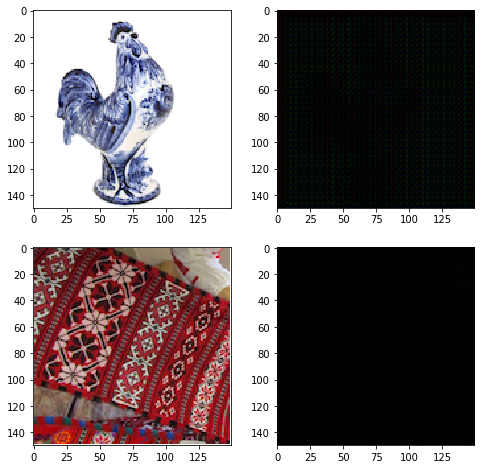

[ 0.49944675  0.49946168  0.49944574  0.49944299  0.4403027   0.44378784
  0.44377029  0.44039249]
[0 0 0 0 1 1 1 1]


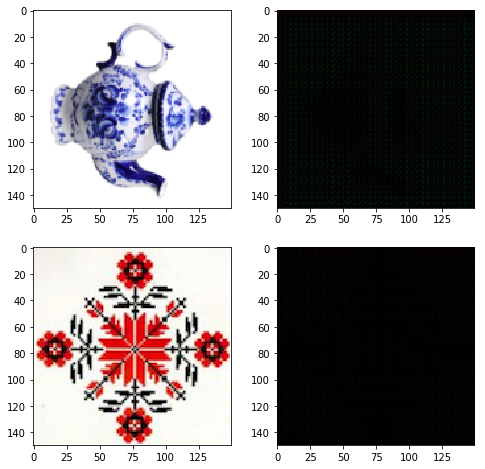

[ 0.49943766  0.49944118  0.49947655  0.49945587  0.43933296  0.44097349
  0.44770426  0.46030965]
[0 0 0 0 1 1 1 1]


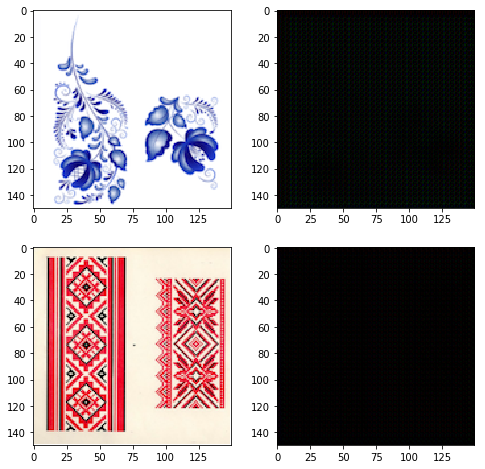

[ 0.49945793  0.49947152  0.49946478  0.49944887  0.44642666  0.44100544
  0.44121093  0.44422865]
[0 0 0 0 1 1 1 1]


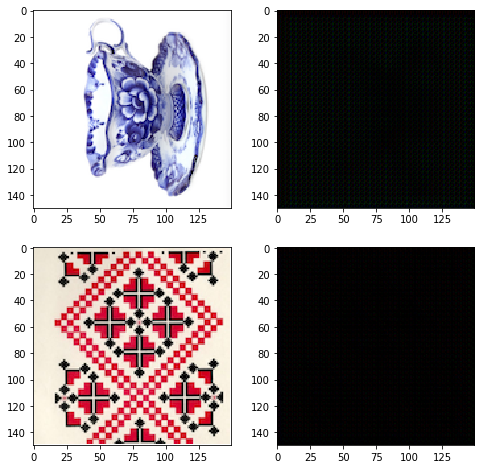

[ 0.49946046  0.4994556   0.49946594  0.49946225  0.44109139  0.44084305
  0.46916586  0.44126064]
[0 0 0 0 1 1 1 1]


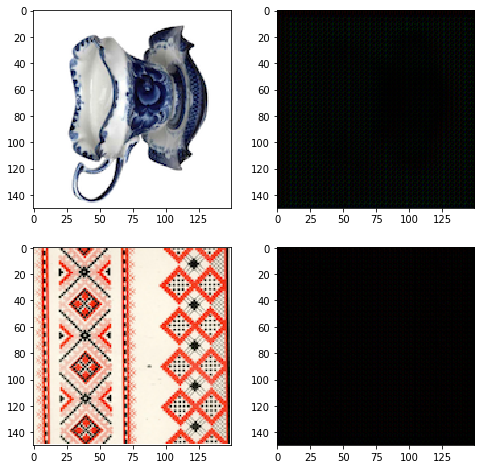

[ 0.49945292  0.4994536   0.49946436  0.49944451  0.44571424  0.44446784
  0.4394986   0.4524155 ]
[0 0 0 0 1 1 1 1]


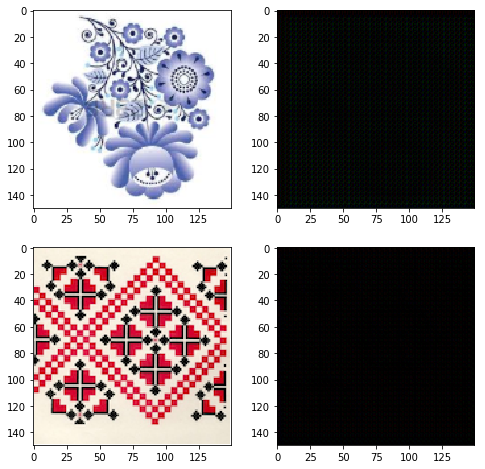

[ 0.49945271  0.49946398  0.49944037  0.49942622  0.44774258  0.46226326
  0.44006929  0.44750586]
[0 0 0 0 1 1 1 1]


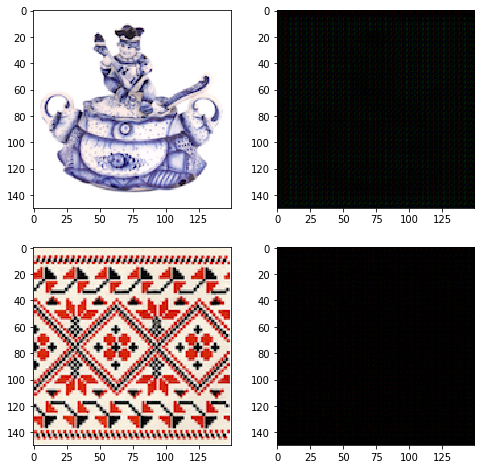

[ 0.49944037  0.4994542   0.49942237  0.49948713  0.44769058  0.44415718
  0.44086906  0.45234844]
[0 0 0 0 1 1 1 1]


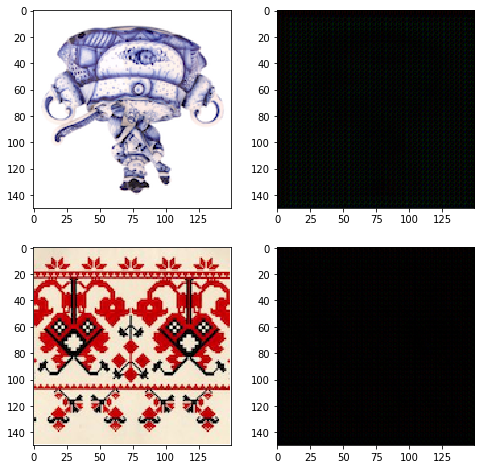

[ 0.49945012  0.49944091  0.49942508  0.49945644  0.44439346  0.43993598
  0.44343665  0.44754472]
[0 0 0 0 1 1 1 1]


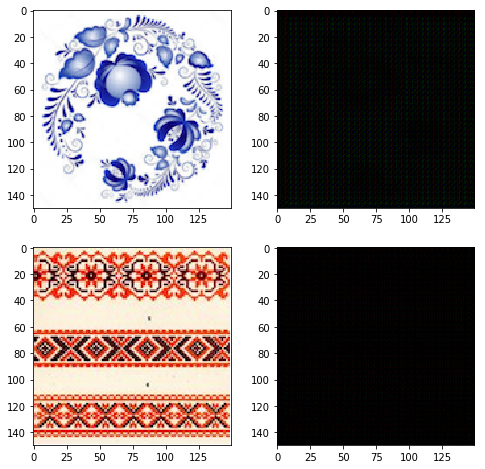

[ 0.49944681  0.49946231  0.49946466  0.49944967  0.4403432   0.44229004
  0.44853923  0.44029751]
[0 0 0 0 1 1 1 1]


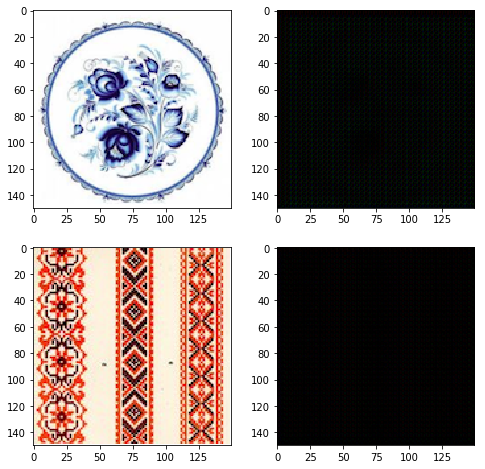

[ 0.49946743  0.49942723  0.49943611  0.49941936  0.43725094  0.46054858
  0.44618225  0.44847032]
[0 0 0 0 1 1 1 1]


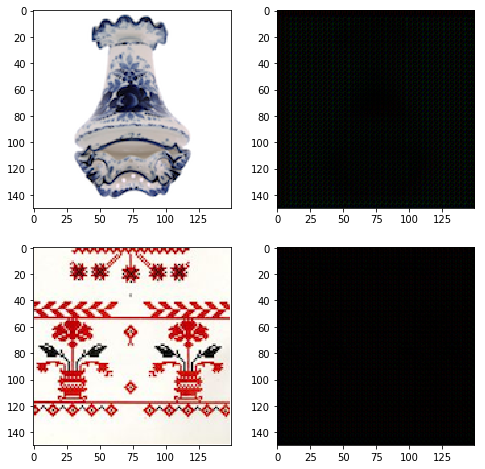

[ 0.49946186  0.49943262  0.49945492  0.49941996  0.45955664  0.44059941
  0.44150758  0.46100193]
[0 0 0 0 1 1 1 1]


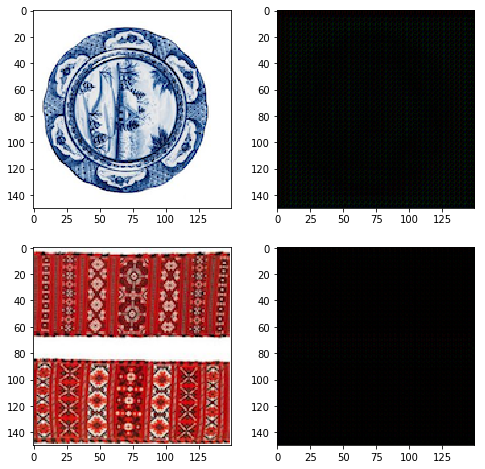

[ 0.49943537  0.49943271  0.49944374  0.49943522  0.44343561  0.44416043
  0.46201438  0.44443995]
[0 0 0 0 1 1 1 1]


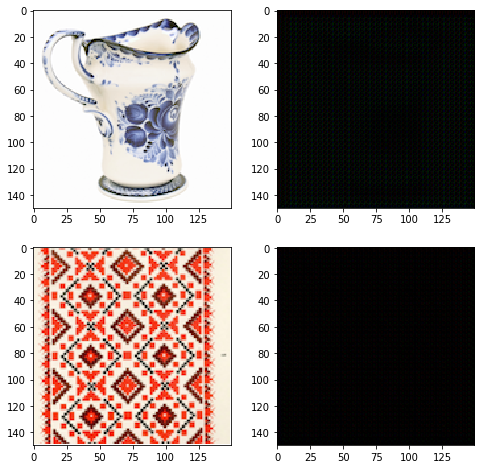

[ 0.49948257  0.49942994  0.49942511  0.49944273  0.44331753  0.44446838
  0.45849296  0.44029   ]
[0 0 0 0 1 1 1 1]


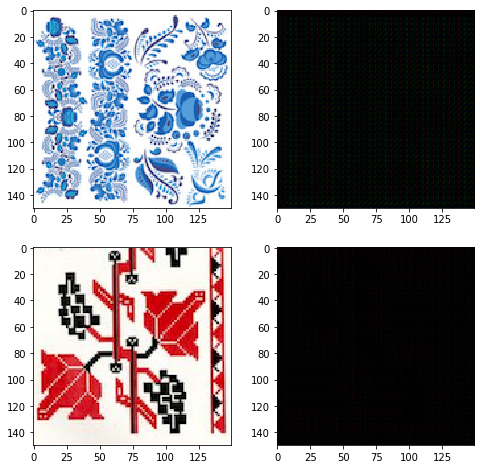

[ 0.49944866  0.49945515  0.49944749  0.49945429  0.4520185   0.44048759
  0.43855956  0.45728219]
[0 0 0 0 1 1 1 1]


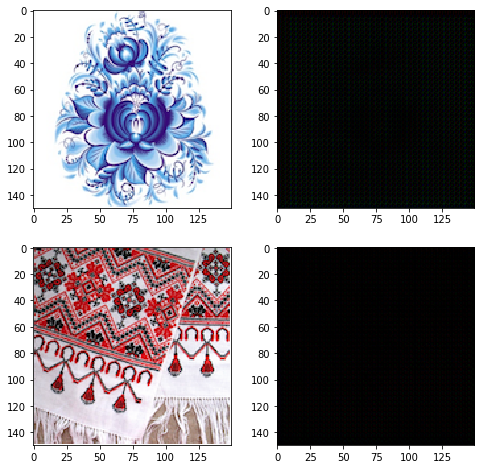

[ 0.49944627  0.49943817  0.49947962  0.49945855  0.45828918  0.43640858
  0.45341748  0.44800144]
[0 0 0 0 1 1 1 1]


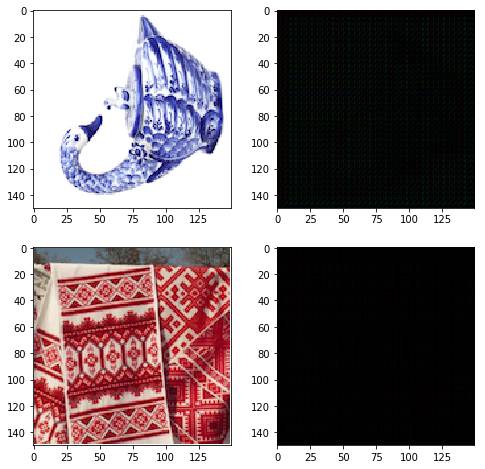

[ 0.49944377  0.49946898  0.49943909  0.49946067  0.44913539  0.44865444
  0.43945351  0.44102532]
[0 0 0 0 1 1 1 1]


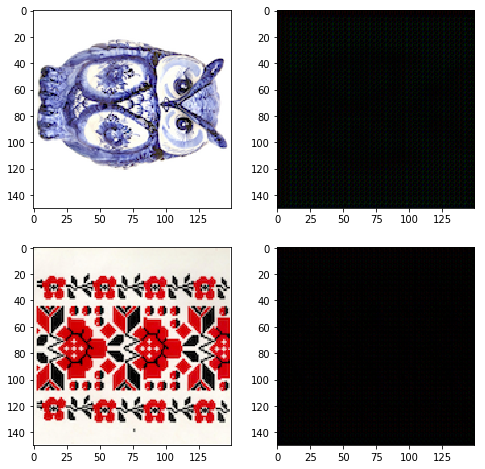

[ 0.49943396  0.49945346  0.4994522   0.49943951  0.45801899  0.43636116
  0.44690818  0.44848028]
[0 0 0 0 1 1 1 1]


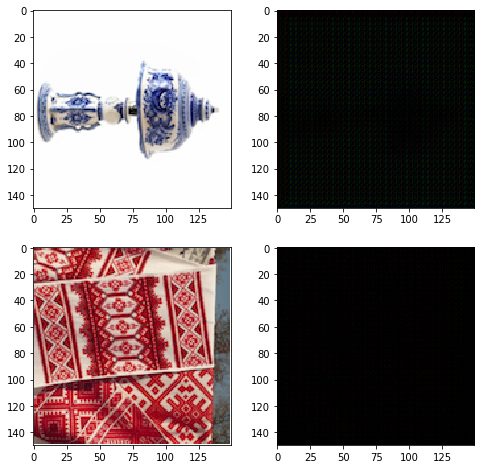

[ 0.49942955  0.49943596  0.49943006  0.49945581  0.44054198  0.4461889
  0.44639432  0.44074363]
[0 0 0 0 1 1 1 1]


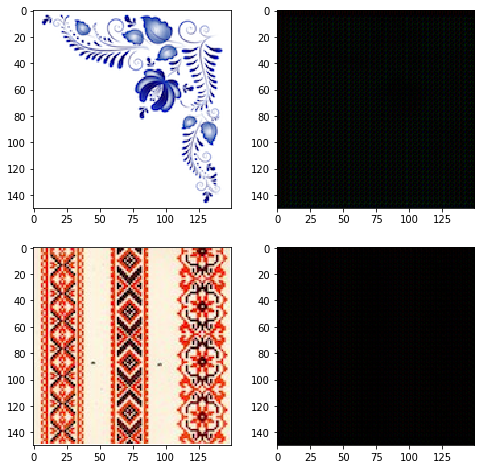

[ 0.49947834  0.49944261  0.49944165  0.4994258   0.45868185  0.44116545
  0.43907386  0.44022593]
[0 0 0 0 1 1 1 1]


KeyboardInterrupt: 

In [11]:
try:
    step = 0   
    # feed data until the epoch limit is reached     
    while not coord.should_stop():
        step += 1
        x, g_x, y, f_y, dy, dy_labels = sess.run([X, G_x, Y, F_y, Dy, Dy_labels])
        print(dy)
        print(dy_labels)
        fig=plt.figure(figsize=(8, 8))
        fig.add_subplot(2, 2, 1)
        plt.imshow(x[0, :, :, :3])
        fig.add_subplot(2, 2, 2)
        plt.imshow(g_x[0, :, :, :3])
        fig.add_subplot(2, 2, 3)
        plt.imshow(y[0, :, :, :3])
        fig.add_subplot(2, 2, 4)
        plt.imshow(f_y[0, :, :, :3])
        plt.show()
        
        
except tf.errors.OutOfRangeError:
    
    print('\nDone training -- epoch limit reached\n')
    
finally:
    
    # when done, ask the threads to stop
    coord.request_stop()

    # wait for threads to finish
    coord.join(threads)
    sess.close()